In [101]:
import cv2
import numpy as np
import subprocess
import os
import tempfile

from matplotlib import pyplot as plt

import math
from sklearn.decomposition import PCA

from PIL import Image

from pixelmatch.contrib.PIL import pixelmatch

from pybind11_pixelmatch import pixelmatch as pixelmatchBind

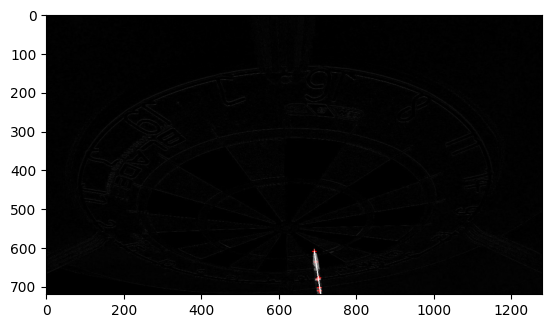

[[692, 610, 1]]
[<__main__.Dart object at 0x169edfe60>, <__main__.Dart object at 0x10459dc10>, <__main__.Dart object at 0x169edca70>]


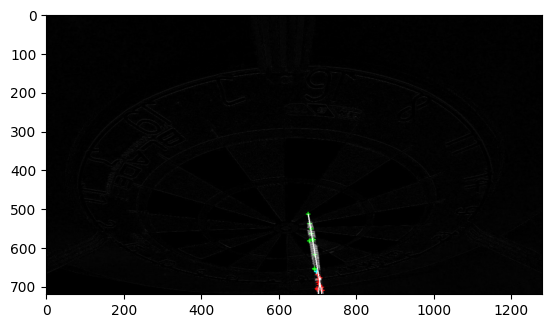

[[700, 669, 1], [676, 514, 2]]
[<__main__.Dart object at 0x16a03df70>, <__main__.Dart object at 0x16a03c110>, <__main__.Dart object at 0x169edd0d0>]


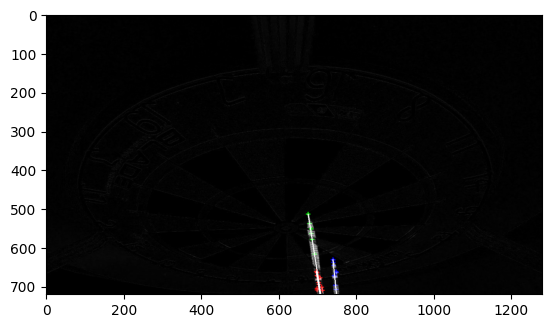

[[697, 662, 1], [676, 514, 2], [740, 631, 3]]


In [ ]:
class Dart:
    def __init__(self, centroids, dartNumber, isStrayGroup, posX, posY):
        self.centroids = centroids
        self.dartNumber = dartNumber
        self.isStrayGroup = isStrayGroup
        self.posX = posX
        self.posY = posY

saveTrackingUtilImages = True
utilImagesCircleDiameter = 3
printLinesIntoResultImage = True
showPixelCoordinatesInResultImage = False  # Can be messy with many darts

currentRunDarts = []
run = 1

# Parameter for the Tracker
# Used for the binary mask to remove occurence of single pixels and strays
baseBinaryThreshhold = 20
min_area_threshold = 5
# Used for the amount of connected dots to be grouped together to recalculate the line
adaptionRate = 3
# Describes the amount of pixel fluctation between the runs within the dart centroid positions
fluctationThreshhold = 7
# Working with the same dart groups in the next run, sometimes new centroids are detected which are part of the old darts. To enable these centroids to be collected turn on recircleUsedDarts.
# The threshhold describes the maximum distance to the line to be added to the dart group
recircleUsedDarts = True
recircleThreshhold = 14
recircleThreshholdUpward = 15
#Defines the maximum between to points for them to be considered grouped together
maxAllowedDistance = 150

#PixelMatch Library Intergration and parameters
usePixelmatchLibraryPIL = False
usePixelmatchLibraryBinded = True
pixelmatchThreshhold = 0.15
pixelmatchUseAA = True

# These are the functions needed for the main part
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def adjust_brightness(image, factor):
    if factor < -255 or factor > 255:
        raise ValueError("Factor must be between -255 and 255.")
    adjusted_image = image.astype(np.int16) + factor
    return np.clip(adjusted_image, 0, 255).astype(np.uint8)

def enhance_contrast(image, factor):
    if factor < 0:
        raise ValueError("Factor must be positive.")
    contrast_image = image.astype(np.int16)
    contrast_image = 128 + factor * (contrast_image - 128)
    return np.clip(contrast_image, 0, 255).astype(np.uint8)

def prepareMask(emptyFrame, dartFrame, baseBinaryThreshhold, usePixelmatch, usePixelmatchBinded, pixelMatchThreshhold, pixelMatchUseAA):
    difference = None
    if usePixelmatch and not usePixelmatchBinded:
        baseBinaryThreshhold += 30
        _, difference = pixelmatchCall(emptyFrame, dartFrame, pixelMatchThreshhold, pixelMatchUseAA)
    elif not usePixelmatch and usePixelmatchBinded:
        baseBinaryThreshhold += 30
        difference = pixelmatchCallBinded(emptyFrame, dartFrame, pixelMatchThreshhold, pixelMatchUseAA)
    elif usePixelmatch and usePixelmatchBinded:
        raise ValueError("Only one pixelmatch library can be used at a time.")
    else: 
        brightness_factor = 10
        empty_dartboard_bright = adjust_brightness(emptyFrame, -brightness_factor)
        dartboard_with_darts_bright = adjust_brightness(dartFrame, 0)

        contrast_factor = 1.2
        empty_dartboard_contrast = enhance_contrast(
            empty_dartboard_bright, contrast_factor
        )
        dartboard_with_darts_contrast = enhance_contrast(
            dartboard_with_darts_bright, 1.3
        )

        empty_gray = cv2.cvtColor(empty_dartboard_contrast, cv2.COLOR_BGR2GRAY)
        darts_gray = cv2.cvtColor(dartboard_with_darts_contrast, cv2.COLOR_BGR2GRAY)

        difference = cv2.absdiff(empty_gray, darts_gray)
        difference = enhance_contrast(difference, 1.8)
        difference = adjust_brightness(difference, 15)

        print(type(difference))

    _, mask = cv2.threshold(difference, baseBinaryThreshhold, 255, cv2.THRESH_BINARY)

    if not usePixelmatch and not usePixelmatchBinded:
        kernel = np.ones((3, 3), np.uint8)
        mask_eroded = cv2.erode(mask, kernel, iterations=1)

        kernel = np.ones((3, 3), np.uint8)
        mask_dilated = cv2.dilate(mask_eroded, kernel, iterations=1)
        mask = mask_dilated

    return difference, mask

def pixelmatchCall(img_a_cv, img_b_cv, pixelMatchThreshhold, pixelMatchUseAA):
    img_a = Image.fromarray(cv2.cvtColor(img_a_cv, cv2.COLOR_BGR2RGB))
    img_b = Image.fromarray(cv2.cvtColor(img_b_cv, cv2.COLOR_BGR2RGB))
    
    img_diff = Image.new("RGBA", img_a.size)

    mismatch = pixelmatch(img_a, img_b, img_diff, pixelMatchThreshhold, pixelMatchUseAA)

    img_diff = np.array(img_diff)
    img_diff = 255 - img_diff

    if img_diff.shape[2] == 4:
        img_diff = cv2.cvtColor(img_diff, cv2.COLOR_RGBA2GRAY)
    elif img_diff.shape[2] == 3:
        img_diff = cv2.cvtColor(img_diff, cv2.COLOR_RGB2GRAY)

    return mismatch, img_diff

def pixelmatchCallBinded(img_a_cv, img_b_cv, pixelMatchThreshhold, pixelMatchUseAA):
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_a, \
         tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_b, \
         tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_out:

        cv2.imwrite(temp_a.name, img_a_cv)
        cv2.imwrite(temp_b.name, img_b_cv)

        cmd = [
            "python3", "-m", "pybind11_pixelmatch",
            temp_a.name, temp_b.name, temp_out.name,
            "--threshold", str(pixelMatchThreshhold),
            "--includeAA", str(pixelMatchUseAA)
        ]

        result = subprocess.run(cmd, capture_output=True, text=True)

        if result.returncode != 0:
            print("Error while running pixelmatch:", result.stderr)
            return None

        img_diff = cv2.imread(temp_out.name, cv2.IMREAD_UNCHANGED)
        img_diff = cv2.cvtColor(img_diff, cv2.COLOR_RGBA2GRAY)
        img_diff = cv2.bitwise_not(img_diff)

        os.remove(temp_a.name)
        os.remove(temp_b.name)
        os.remove(temp_out.name)

        return img_diff


def findPointsInMask(mask, min_area_threshold):
    # Find Centerpoints in Contours of Mask
    contours_in_mask, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    centroids = []

    for contour_mask in contours_in_mask:
        area = cv2.contourArea(contour_mask)

        if area > min_area_threshold:
            # Append Highgest Point
            topmost_point = min(contour_mask, key=lambda point: point[0][1])
            cx, cy = int(topmost_point[0][0]), int(topmost_point[0][1])
            centroids.append((cx, cy))
            # Append Centerpoints
            M = cv2.moments(contour_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))
    return centroids

def findDartPositions(groups, currentRunDarts):
    used_positions = {
        (dart.posX, dart.posY) for dart in currentRunDarts if not dart.isStrayGroup
    }
    for group in groups:
        if group.isStrayGroup or (group.posX, group.posY) in used_positions:
            continue

        sorted_group = sorted(group.centroids, key=lambda y: y[1])
        group.posX = sorted_group[0][0]
        group.posY = sorted_group[0][1]
    return groups

def findClosestPoint(current_point, centroids, maxAllowedDistance):
    nearest_point = None
    min_distance = float("inf")
    for centroid in centroids:
        distance = euclidean_distance(centroid, current_point)

        if distance < min_distance and distance <= maxAllowedDistance:
            min_distance = distance
            nearest_point = centroid
    return nearest_point

def findClosestPointBasedOnLine(
    slope, intercept, points, init_y, used_points, tolerance=2
):
    nearest_point = None
    min_distance_to_line = float("inf")

    for point in points:
        x0, y0 = point

        if any(
            abs(x0 - ux) <= tolerance and abs(y0 - uy) <= tolerance
            for ux, uy in used_points
        ):
            continue

        y_position_on_dart = abs(y0 - init_y)

        # Expand the threshhold for the distance to the line based on the y-position difference to the dart
        if y_position_on_dart < 200:
            max_distance_threshhold = 25
        elif y_position_on_dart < 300:
            max_distance_threshhold = 30
        elif y_position_on_dart < 400:
            max_distance_threshhold = 35
        else:
            max_distance_threshhold = 85

        if slope == float("inf"):
            distance_to_line = abs(x0 - intercept)
        else:
            distance_to_line = abs(slope * x0 - y0 + intercept) / np.sqrt(
                slope**2 + 1
            )

        if (
            distance_to_line < min_distance_to_line
            and distance_to_line < max_distance_threshhold
        ):
            min_distance_to_line = distance_to_line
            nearest_point = point

    return nearest_point

def calculateLine(points):
    x = np.array([point[0] for point in points])
    y = np.array([point[1] for point in points])

    # PCA Principal Component Analysis
    pca = PCA(n_components=1)
    pca.fit(points)

    direction = pca.components_[0]

    if direction[0] == 0:
        return float("inf"), np.mean(x)

    slope = direction[1] / direction[0]
    intercept = np.mean(y) - slope * np.mean(x)

    return slope, intercept

def drawLine(slope, line_mask, start_point):
    try:
        if slope == float("NaN") or slope == float("inf"):
            return
        line_length = 600

        x_offset = line_length / np.sqrt(1 + slope**2)
        y_offset = slope * x_offset

        if x_offset == float("NaN") or y_offset == float("NaN"):
            return

        end_point = (
            int(start_point[0] + (x_offset if slope >= 0 else -x_offset)),
            int(start_point[1] + (y_offset if slope >= 0 else -y_offset)),
        )

        cv2.line(line_mask, start_point, end_point, (255, 255, 255), 2)
    except ValueError:
        print("VALUE ERROR")
        print(f"slope: {slope}")

def groupDots(
    centroids,
    point_mask,
    line_mask,
    adapting_rate,
    currentRunDarts,
    fluctationThreshhold,
    recircleUsedDarts,
    recircleThreshhold,
    upwardsThreshhold,
    maxAllowedDistance
):
    groups = []
    used_points = set()

    if len(currentRunDarts) > 0:
        groups, centroids, used_points = analyzeDartCorrespondences(
            centroids,
            currentRunDarts,
            fluctationThreshhold,
            recircleUsedDarts,
            recircleThreshhold,
            upwardsThreshhold,
            line_mask,
        )

    current_point = getTopMostPoint(centroids)
    if current_point is not None:
        processGrouping(
            current_point,
            centroids,
            point_mask,
            line_mask,
            adapting_rate,
            used_points,
            fluctationThreshhold,
            groups,
            maxAllowedDistance
        )

    if len(centroids) > 0:
        groups.append(Dart(centroids, 0, isStrayGroup=True, posX=0, posY=0))

    return groups, point_mask, line_mask

def analyzeDartCorrespondences(
    centroids,
    currentRunDarts,
    fluctationThreshhold,
    recircleUsedDarts,
    recircleThreshhold,
    upwardsThreshhold,
    line_mask,
):
    groups = []
    remaining_centroids = centroids.copy()
    used_points = set()

    for dart in currentRunDarts:
        if dart.isStrayGroup:
            continue

        corresponding_points = [
            point for point in remaining_centroids
            if any(
                abs(point[0] - centroid[0]) <= fluctationThreshhold
                and abs(point[1] - centroid[1]) <= fluctationThreshhold
                for centroid in dart.centroids
            )
        ]

        if not corresponding_points or len(corresponding_points) < 3:
            continue

        highest_point = min(corresponding_points, key=lambda p: p[1], default=None)

        used_points.update(corresponding_points)
        for point in corresponding_points:
            remaining_centroids.remove(point)

        dart_points = corresponding_points.copy()

        groups.append(
            Dart(
                dart_points,
                len(groups) + 1,
                isStrayGroup=False,
                posX=highest_point[0],
                posY=highest_point[1],
            )
        )

    if recircleUsedDarts:
        for group in groups:
            slope, intercept = calculateLine(group.centroids)
            if printLinesIntoResultImage:
                drawLine(slope, line_mask, (group.posX, group.posY))
            added_points = set()

            for point in remaining_centroids:
                x0, y0 = point
                distance = abs(slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)

                if distance <= recircleThreshhold and y0 >= group.posY - upwardsThreshhold:
                    added_points.add((x0, y0))

            group.centroids.extend(added_points)
            used_points.update(added_points)
            for point in added_points:
                remaining_centroids.remove(point)

    return groups, remaining_centroids, used_points

def processGrouping(
    current_point,
    centroids,
    point_mask,
    line_mask,
    adaption_rate,
    used_points,
    fluctationThreshhold,
    groups,
    maxAllowedDistance
):
    centroids.remove(current_point)
    if len(centroids) == 0:
        groups.append(Dart([current_point], 0, isStrayGroup=True, posX=0, posY=0))
        return
    nearest_points = [current_point]
    tmp_point = current_point

    for _ in range(min(len(centroids), adaption_rate)):
        nearest_point = findNextPoint(
            tmp_point, centroids, used_points, fluctationThreshhold, maxAllowedDistance
        )
        if nearest_point:
            tmp_point = nearest_point
            nearest_points.append(tmp_point)
            centroids.remove(nearest_point)

    slope, intercept = calculateLine(nearest_points)
    if printLinesIntoResultImage:
        drawLine(slope, line_mask, nearest_points[0])

    updateLineAndGroup(
        nearest_points,
        centroids,
        slope,
        intercept,
        line_mask,
        used_points,
        fluctationThreshhold,
        adaption_rate,
    )

    if saveTrackingUtilImages:
        drawGroupedPoints(nearest_points, point_mask, line_mask)

    groups.append(Dart(nearest_points, len(groups) + 1, isStrayGroup=False, posX=0, posY=0))

def getTopMostPoint(centroids):
    if not centroids:
        return None
    return min(centroids, key=lambda point: point[1])

def findNextPoint(current_point, centroids, used_points, threshhold, maxAllowedDistance):
    # Add Threhshold for pixel fluctation between runtimes
    new_points = [
        p
        for p in centroids
        if not any(
            abs(p[0] - ux) <= threshhold and abs(p[1] - uy) <= threshhold
            for ux, uy in used_points
        )
    ]
    if new_points:
        return findClosestPoint(current_point, new_points, maxAllowedDistance)
    return findClosestPoint(current_point, centroids, maxAllowedDistance)

def updateLineAndGroup(
    nearest_points,
    centroids,
    slope,
    intercept,
    line_mask,
    used_points,
    threshhold,
    adaption_rate,
):
    points_grouped = 0
    init_y = nearest_points[0][1]

    while True:
        nearest_point = findClosestPointBasedOnLine(
            slope, intercept, centroids, init_y, used_points, threshhold
        )
        if not nearest_point:
            break

        centroids.remove(nearest_point)
        nearest_points.append(nearest_point)
        points_grouped += 1

        if points_grouped % adaption_rate == 0:
            slope, intercept = calculateLine(nearest_points)
        elif points_grouped % 7 == 0 and printLinesIntoResultImage:
            drawLine(slope, line_mask, nearest_points[0])

def drawGroupedPoints(nearest_points, point_mask, line_mask):
    color = (85, 195, 189)
    for point in nearest_points:
        cv2.circle(point_mask, point, 3, color, -1)
    point_mask = cv2.add(point_mask, line_mask)

def drawCrossWithCoordinates(groups, dartFrame, colors, show_coordinates):
    mask3 = np.zeros_like(dartFrame) 

    for index, group in enumerate(groups):
        if group.isStrayGroup:
            color = colors[len(colors)-1] 
        else:   
            color = colors[index % len(colors)] 
        for (cx, cy) in group.centroids:
            cv2.line(mask3, (cx - 5, cy), (cx + 5, cy), color, 2) 
            cv2.line(mask3, (cx, cy - 5), (cx, cy + 5), color, 2)
            
            if show_coordinates:
                coordinate_text = f"({cx}, {cy})"
                cv2.putText(mask3, coordinate_text, (cx + 10, cy - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    
    return mask3

#Print out the results of the functions
def main(dart_frame, clean_frame, run=run):
    dartFrameRotated = cv2.rotate(dart_frame, cv2.ROTATE_180)
    emptyFrameRotated = cv2.rotate(clean_frame, cv2.ROTATE_180)

    gray_dart = cv2.cvtColor(dartFrameRotated, cv2.COLOR_BGR2GRAY)
    gray_empty = cv2.cvtColor(emptyFrameRotated, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray_dart, gray_empty)
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2BGR)

    # Build difference so only darts are left
    mask0, mask1 = prepareMask(dartFrameRotated, emptyFrameRotated, baseBinaryThreshhold, usePixelmatchLibraryPIL, usePixelmatchLibraryBinded, pixelmatchThreshhold, pixelmatchUseAA)

    mask2 = np.zeros_like(mask1)
    # Find centroid points in mask, draw them into an empty mask, min area threshold removes strays
    centroids = findPointsInMask(mask1, min_area_threshold)
    if saveTrackingUtilImages:
        for cx, cy in centroids:
            cv2.circle(
                mask2, (cx, cy), utilImagesCircleDiameter, (255, 0, 0), -1
            )

    point_mask = np.zeros_like(dart_frame)
    # For Line Mask to be filled, set printLinesIntoResultImage to True
    line_mask = np.zeros_like(dart_frame)

    groups, point_mask, line_mask = groupDots(
        centroids,
        point_mask,
        line_mask,
        adaptionRate,
        currentRunDarts,
        fluctationThreshhold,
        recircleUsedDarts,
        recircleThreshhold,
        recircleThreshholdUpward,
        maxAllowedDistance
    )

    # Neglect strays and find positions for the dart groups
    darts = findDartPositions(groups, currentRunDarts)
    currentRunDarts.clear()
    currentRunDarts.extend(darts)

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]

    mask3 = drawCrossWithCoordinates(
        groups, dart_frame, colors, showPixelCoordinatesInResultImage
    )
    mask3 = cv2.add(line_mask, mask3)

    result_image = cv2.add(mask3, difference)
    if saveTrackingUtilImages:
        print(darts)
        cv2.imwrite("difference_" + run + ".jpg", difference)
        cv2.imwrite("mask0_" + run + ".jpg", mask0)
        cv2.imwrite("mask1_" + run + ".jpg", mask1)
        cv2.imwrite("mask2_" + run + ".jpg", mask2)
        cv2.imwrite("mask3_" + run + ".jpg", mask3)
        cv2.imwrite("result_" + run + ".jpg", result_image)
        cv2.imwrite("point_mask_" + run + ".jpg", point_mask)
        plt.imshow(result_image)
        plt.show()

    return [[dart.posX, dart.posY, dart.dartNumber] for dart in darts[0:3] if not dart.isStrayGroup]

#Testing Function
def process_dart_images(folder, side):
    if side.lower() not in ["left", "right"]:
        raise ValueError("Seite muss 'left' oder 'right' sein.")

    base_path = f"./images_new/intervalls/{folder}/"
    empty_image_path = f"{base_path}Empty{side.capitalize()}.jpg"
    dart_image_names = [f"Single{side.capitalize()}.jpg", 
                        f"Double{side.capitalize()}.jpg", 
                        f"Triple{side.capitalize()}.jpg"
                        ]

    empty_frame = cv2.imread(empty_image_path)
    if empty_frame is None:
        raise FileNotFoundError(f"Leeres Bild nicht gefunden: {empty_image_path}")

    results = []
    for index, dart_image_name in enumerate(dart_image_names, start=1):
        dart_frame = cv2.imread(f"{base_path}{dart_image_name}")
        if dart_frame is None:
            raise FileNotFoundError(f"Dart-Bild nicht gefunden: {base_path}{dart_image_name}")
        
        result = main(dart_frame, empty_frame, str(index))
        print(result)
        results.append(result)

    return results

process_dart_images("3", "left")

def process_dart_image_with_fluctuation(folder, side, num_iterations=5):
    if side.lower() not in ["left", "right"]:
        raise ValueError("Seite muss 'left' oder 'right' sein.")

    base_path = f"./images_new/intervalls/{folder}/"
    empty_image_path = f"{base_path}Empty{side.capitalize()}.jpg"
    dart_image_path = f"{base_path}Single{side.capitalize()}.jpg"

    # Liste der möglichen Fluktuationspunkte
    fluctuation_points = [(443, 543), 
                          #(450, 533), 
                          #(457, 517), 
                          #(440, 590), 
                          (438, 632)]  

    empty_frame = cv2.imread(empty_image_path)
    if empty_frame is None:
        raise FileNotFoundError(f"Leeres Bild nicht gefunden: {empty_image_path}")

    dart_frame = cv2.imread(dart_image_path)
    if dart_frame is None:
        raise FileNotFoundError(f"Dart-Bild nicht gefunden: {dart_image_path}")

    results = []
    for i in range(num_iterations):
        selected_points = fluctuation_points[:i%len(fluctuation_points)+1]
        
        result = main(dart_frame, empty_frame, True, str(i + 1), selected_points)
        print(result)
        results.append(result)

    return results

#process_dart_image_with_fluctuation("2", "right", num_iterations=2)
#process_dart_images("2", "right")
